# Simulated DCA Demo

In [1]:
from hyppo.tools import SIMULATIONS
from matplotlib import cm
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import numpy as np
from numpy import linalg as LA

import dist_cov as dc

In [2]:
np.random.seed(4)

# 1D Simulated Linear Independence Data
## Plot Dataset

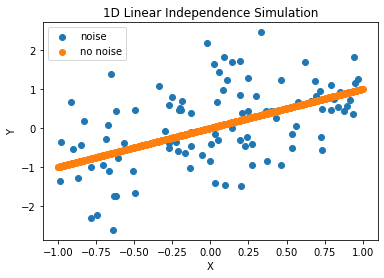

In [3]:
lin_sim = SIMULATIONS["linear"]
lin_x_n, lin_y_n = lin_sim(100, 1, noise=True)
lin_x, lin_y = lin_sim(1000, 1)
plt.scatter(lin_x_n, lin_y_n)
plt.scatter(lin_x, lin_y)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("1D Linear Independence Simulation")
plt.legend(["noise", "no noise"]);

## Initialize Data

In [4]:
X, Y = lin_sim(100, 1, noise=True)
N = 10
D_X = dc.dist_mat(X, N)
D_Y = dc.dist_mat(Y, N)
R_X = dc.re_centered_dist(D_X)
R_Y = dc.re_centered_dist(D_Y)
u = np.random.rand(X.shape[1], 1)
u = dc.clamp_u(u)
u_norm = LA.norm(u)
print(f"X shape: {X.shape}")
print(f"Y shape: {Y.shape}")
print(f"u: {u}")
print(f"u norm: {u_norm}")
R_X_u = dc.re_centered_dist_u(u, X, N)

X shape: (100, 1)
Y shape: (100, 1)
u: [[0.88007462]]
u norm: 0.8800746244295826


## Test Function Dimension Alignment

In [5]:
du = dc.dist_cov_sq_grad(u, X, Y, R_X, R_Y)
print(f"dvdu: {du}")
v = dc.dist_cov_sq(R_X, R_Y)
print(f"v^2: {v}")

dvdu: [0.1579539]
v^2: 0.15795390403284906


## Optimize $u$

In [6]:
v_u = dc.dist_cov_sq(R_Y, R_X_u)
print(f"v^2_u: {v_u}")
u_opt = dc.optim_u_gd(u, X, Y, R_X, R_Y, .1, 1000)
print(f"u opt: {u_opt}")
R_X_u_opt = dc.re_centered_dist_u(u_opt, X, N)
v_u_opt = dc.dist_cov_sq(R_Y, R_X_u_opt)
print(f"v^2_u_opt: {v_u_opt}")

v^2_u: 0.13901122276889596
u opt: [[1.]]
v^2_u_opt: 0.15795390403284906


## Plot Gradient Ascent

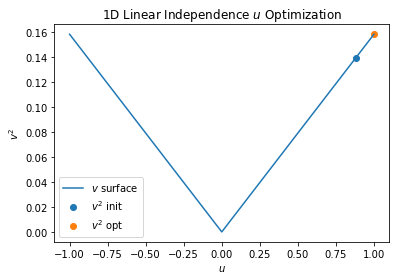

In [7]:
u_plt = np.expand_dims(np.linspace(-1, 1, 11), 1)
v_u_plt = np.zeros_like(u_plt)
for i in range(u_plt.shape[0]):
    R_X_u_i = dc.re_centered_dist_u(u_plt[i], X, N)
    v_u_i = dc.dist_cov_sq(R_Y, R_X_u_i)
    v_u_plt[i] = v_u_i
plt.plot(u_plt, v_u_plt)
plt.scatter([u], [v_u])
plt.scatter([u_opt], [v_u_opt])
plt.xlabel(r"$u$")
plt.ylabel(r"$v^2$")
plt.title(r"1D Linear Independence $u$ Optimization")
plt.legend([r'$v$ surface', r'$v^2$ init', r'$v^2$ opt']);

# 2D Simulated Linear Independence Data
## Plot Dataset

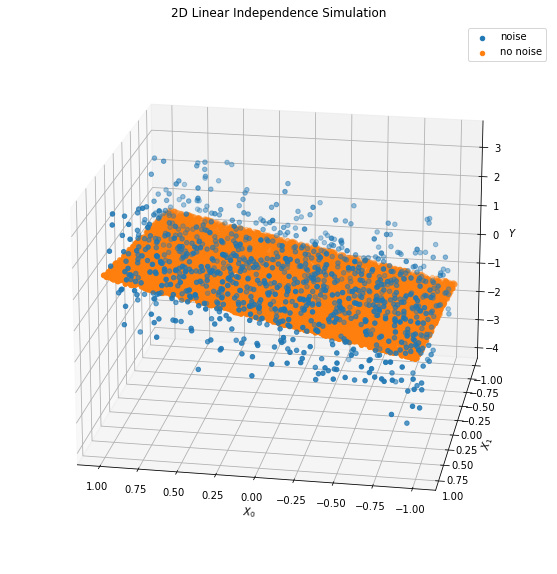

In [8]:
lin_sim = SIMULATIONS["linear"]
lin_x_n, lin_y_n = lin_sim(1000, 2, noise=True)
lin_x, lin_y = lin_sim(10000, 2)

lin_x_1_n = lin_x_n[:, 0]
lin_x_2_n = lin_x_n[:, 1]
lin_x_1 = lin_x[:, 0]
lin_x_2 = lin_x[:, 1]

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
ax.scatter(lin_x_1_n, lin_x_2_n, lin_y_n)
ax.scatter(lin_x_1, lin_x_2, lin_y)
ax.set_xlabel(r"$X_0$")
ax.set_ylabel(r"$X_1$")
ax.set_zlabel(r"$Y$")
plt.title("2D Linear Independence Simulation")
plt.legend(["noise", "no noise"])
ax.view_init(elev=20, azim=100);

## Initialize Data

In [9]:
X, Y = lin_sim(100, 2, noise=True)
N = 10
D_X = dc.dist_mat(X, N)
D_Y = dc.dist_mat(Y, N)
R_X = dc.re_centered_dist(D_X)
R_Y = dc.re_centered_dist(D_Y)
u = np.random.rand(X.shape[1])
u = dc.clamp_u(u)
u_norm = LA.norm(u)
print(f"X shape: {X.shape}")
print(f"Y shape: {Y.shape}")
print(f"u: {u}")
print(f"u norm: {u_norm}")
R_X_u = dc.re_centered_dist_u(u, X, N)

X shape: (100, 2)
Y shape: (100, 1)
u: [0.68760595 0.72608405]
u norm: 0.9999999999999999


## Test Function Dimension Alignment

In [10]:
du = dc.dist_cov_sq_grad(u, X, Y, R_X, R_Y)
print(f"dvdu: {du}")
v = dc.dist_cov_sq(R_X, R_Y)
print(f"v^2: {v}")

dvdu: [0.02671146 0.01173224]
v^2: 0.08150051732339861


## Optimize $u$

In [11]:
v_u = dc.dist_cov_sq(R_Y, R_X_u)
print(f"v^2_u: {v_u}")
u_opt = dc.optim_u_gd(u, X, Y, R_X, R_Y, .1, 1000)
print(f"u opt: {u_opt}")
R_X_u_opt = dc.re_centered_dist_u(u_opt, X, N)
v_u_opt = dc.dist_cov_sq(R_Y, R_X_u_opt)
print(f"v^2_u_opt: {v_u_opt}")

v^2_u: 0.02688555078820328
u opt: [ 0.99479497 -0.10189681]
v^2_u_opt: 0.10106548215456122


## Plot Gradient Ascent

In [12]:
X_surf = np.arange(-1, 1, 0.01)
Y_surf = np.arange(-1, 1, 0.01)
X_surf, Y_surf = np.meshgrid(X_surf, Y_surf)
v_u_plt = np.zeros_like(X_surf)
for i in range(X_surf.shape[0]):
    for j in range(X_surf.shape[1]):
        R_X_u_i = dc.re_centered_dist_u(np.array([X_surf[i, j], Y_surf[i, j]]), X, N)
        v_u_i = dc.dist_cov_sq(R_Y, R_X_u_i)
        v_u_plt[i, j] = v_u_i

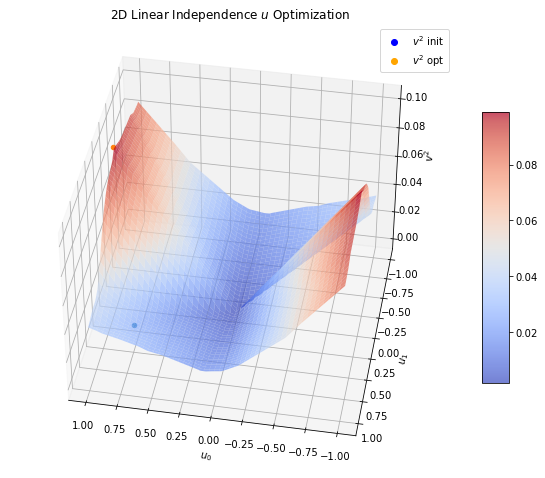

In [13]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(10,10))
surf = ax.plot_surface(X_surf, Y_surf, v_u_plt, cmap=cm.coolwarm, linewidth=0, antialiased=True, alpha=.7)
ax.scatter([u[0]], [u[1]], [v_u])
ax.scatter([u_opt[0]], [u_opt[1]], [v_u_opt])
ax.set_xlabel(r"$u_0$")
ax.set_ylabel(r"$u_1$")
ax.set_zlabel(r"$v^2$")
ax.set_title(r"2D Linear Independence $u$ Optimization")
init_proxy = Line2D([0], [0], linestyle="none", c='blue', marker='o')
opt_proxy = Line2D([0], [0], linestyle="none", c='orange', marker='o')
ax.legend([init_proxy, opt_proxy], [r'$v^2$ init', r'$v^2$ opt'], numpoints=1)
fig.colorbar(surf, shrink=0.5, aspect=10)
ax.view_init(elev=40, azim=100);

# nD Simulated Linear Independence Data
## Initialize Data

In [14]:
lin_sim = SIMULATIONS["linear"]
X, Y = lin_sim(100, 10, noise=True)
N = 100
D_X = dc.dist_mat(X, N)
D_Y = dc.dist_mat(Y, N)
R_X = dc.re_centered_dist(D_X)
R_Y = dc.re_centered_dist(D_Y)
u = np.random.rand(X.shape[1])
u = dc.clamp_u(u)
u_norm = LA.norm(u)
print(f"X shape: {X.shape}")
print(f"Y shape: {Y.shape}")
print(f"u: {u}")
print(f"u norm: {u_norm}")
R_X_u = dc.re_centered_dist_u(u, X, N)

X shape: (100, 10)
Y shape: (100, 1)
u: [0.47415625 0.03032833 0.45173156 0.02802985 0.24710329 0.34292285
 0.47052132 0.13815013 0.38431762 0.05076468]
u norm: 1.0


## Test Function Dimension Alignment

In [15]:
du = dc.dist_cov_sq_grad(u, X, Y, R_X, R_Y)
print(f"dvdu: {du}")
v = dc.dist_cov_sq(R_X, R_Y)
print(f"v^2: {v}")

dvdu: [ 0.04636159  0.0508426   0.02147206  0.02226291 -0.00356196  0.00420046
 -0.0023292   0.0018721  -0.00307154  0.00055741]
v^2: 0.05473873457105564


## Optimize $u$

In [16]:
v_u = dc.dist_cov_sq(R_Y, R_X_u)
print(f"v^2_u: {v_u}")
u_opt = dc.optim_u_gd(u, X, Y, R_X, R_Y, .1, 100)
print(f"u opt: {u_opt}")
R_X_u_opt = dc.re_centered_dist_u(u_opt, X, N)
v_u_opt = dc.dist_cov_sq(R_Y, R_X_u_opt)
print(f"v^2_u_opt: {v_u_opt}")

v^2_u: 0.03241904350979828
u opt: [0.66143122 0.48553452 0.4035026  0.21123739 0.04279812 0.23022423
 0.23284919 0.02552498 0.08100231 0.05534319]
v^2_u_opt: 0.0885924927864048
